# Hospital Acquired Complications (HACs) Model Training and Evaluation

Import libraries

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_sample_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc



from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
pd.set_option('display.max_columns', None)  # None ensures all columns are shown
warnings.simplefilter(action='ignore', category=FutureWarning)

Read pre-processed data "all_encoded_df"

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the file
file_id = '1-9Tp6ZMZG9zKieBTO_Sd6W-HdzXPy5OL'
file_name = 'selected_features_500.csv'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_name)

# Read into DataFrame
selected_features_df = pd.read_csv(file_name)
selected_features_df.shape

(58976, 501)

In [2]:
best_500 = pd.read_csv('selected_features_500.csv')
selected_features_df = best_500

In [5]:
selected_features_df.head()

,DIAGNOSIS_UNSTABLE ANGINA\CATH,ROUTE_SCIVPOPR,ROUTE_PO/NGIVSCIH,ROUTE_POIVIHSCTP,virus,ROUTE_IVSCPOIHTP,ROUTE_IVSCPO/NGIH,DIAGNOSIS_HYPOGLYCEMIA,DIAGNOSIS_CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA,ROUTE_POIVSCTPPRIH,ROUTE_IVPOPRIHSC,DIAGNOSIS_CORONARY ARTERY DISEASE\CATH,ROUTE_POIVSCTPIH,ROUTE_POIVPR,ROUTE_IVPOIHPRSC,ROUTE_POIVPRTPSC,DIAGNOSIS_CHOLECYSTITIS,ETHNICITY_WHITE - BRAZILIAN,ROUTE_SCPOIVTP,ROUTE_IVPOIH,DIAGNOSIS_HEPATIC ENCEPHALOPATHY,ROUTE_IVPO/NGIHSC,ROUTE_IHPOIVSCPRTP,mold,aspergillus fumigatus,DIAGNOSIS_CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT/SDA,ROUTE_SCPOIV,ROUTE_IVPO/NGSCIH,DIAGNOSIS_UNRESPONSIVE,ROUTE_IVPOIHPRSCTP,DIAGNOSIS_AORTIC STENOSIS\AORTIC VALVE REPLACEMENT/SDA,DIAGNOSIS_OVERDOSE,DIAGNOSIS_ATRIAL FIBRILLATION,"Hematocrit, Ascites",DIAGNOSIS_S/P CARDIAC ARREST,Young Cells,ROUTE_IVSCPRPO,ROUTE_POIHSCIVPR,probable micrococcus sp,haemophilus influenzae beta lactamase pos,anaerobic gram pos rod s,ROUTE_PO/NGIVSCTPPR,Blasts,DIAGNOSIS_ALCOHOL WITHDRAWAL,Theophylline,herpes simplex virus type 1,DIAGNOSIS_ABDOMINAL AORTIC ANEURYSM,ROUTE_POIVTP,ROUTE_IVPO/NGSCTPPR,ROUTE_POIVTPSCPR,25-OH Vitamin D,DIAGNOSIS_CHF EXACERBATION,ROUTE_IVPO/NGTPSC,ROUTE_POIVIHSCPRTP,ROUTE_IVSCPOIHPR,DIAGNOSIS_ASTHMA;CHRONIC OBST PULM DISEASE,WBC Casts,DIAGNOSIS_STROKE,DIAGNOSIS_PLEURAL EFFUSION,"Protein C, Functional",DIAGNOSIS_PULMONARY EMBOLIS,ROUTE_POIVSCIHPRTP,DIAGNOSIS_BRAIN MASS,DIAGNOSIS_HYPERGLYCEMIA,ROUTE_POIVTPSC,ROUTE_POIVSCIHTP,DIAGNOSIS_ASTHMA/COPD EXACERBATION,ROUTE_POIVSCPRIHTP,ROUTE_IV DRIPPOSC,streptococcus sp,DIAGNOSIS_ABDOMINAL AORTIC ANEURYSM/SDA,"Hematocrit, Other Fluid",DIAGNOSIS_CHOLANGITIS,ETHNICITY_HISPANIC/LATINO - DOMINICAN,DIAGNOSIS_SMALL BOWEL OBSTRUCTION,ROUTE_POIVSCTPPR,ROUTE_IVSCPOPRIH,moraxella catarrhalis,DIAGNOSIS_CHEST PAIN\CATH,ROUTE_IVPOSCTPIH,ROUTE_IVPOPRTPSC,ROUTE_POIVIHPRSC,DIAGNOSIS_STROKE;TELEMETRY,ROUTE_POIVSCIHTPPR,ROUTE_IVPOIHSCTP,probable gardnerella vaginalis,ROUTE_IVPOSCTPIHPR,DIAGNOSIS_BRADYCARDIA,Beta-2 Microglobulin,DIAGNOSIS_SEIZURES,DIAGNOSIS_ASTHMA;COPD EXACERBATION,Factor VIII,ROUTE_IVSCPO/NG,ROUTE_IVSCPOIH,CD4/CD8 Ratio,DIAGNOSIS_DEHYDRATION,DIAGNOSIS_SUBDURAL HEMORRHAGE,DIAGNOSIS_CELLULITIS,ROUTE_POPRIVSC,ROUTE_IV DRIPPOPRSC,WBC Count,DIAGNOSIS_HYPERKALEMIA,ROUTE_IVPOPR,DIAGNOSIS_MENTAL STATUS CHANGES,DISCHARGE_LOCATION_LEFT AGAINST MEDICAL ADVI,ROUTE_IHIVPOSC,ROUTE_PO/NGIVPRSC,DIAGNOSIS_HYPOXIA,Prolactin,Hypersegmented Neutrophils,"Hematocrit, Pleural",ROUTE_IVPOPRSCIH,ETHNICITY_BLACK/HAITIAN,Rapamycin,DIAGNOSIS_UNSTABLE ANGINA,ROUTE_PO/NGIVSCPR,ROUTE_POSCIVPR,DISCHARGE_LOCATION_ICF,ROUTE_SCIVPO,DIAGNOSIS_LIVER FAILURE,ROUTE_IVIHPOSC,gram pos rods,ROUTE_IVPOIHSCPR,Alpha-Fetoprotein,DIAGNOSIS_GI BLEED,DIAGNOSIS_BOWEL OBSTRUCTION,ROUTE_POIVSCPRIH,ROUTE_POIVSCPRTP,DIAGNOSIS_CARDIAC ARREST,ROUTE_IV,non fermenter not pseudomonas aeruginosa,Carbamazepine,Procedure: Hip and Soft Tissue Procedures,DIAGNOSIS_AORTIC DISSECTION,ROUTE_IVPO/NGSCTP,ROUTE_POIVPRSCIH,DIAGNOSIS_LOWER GASTROINTESTINAL BLEED,DIAGNOSIS_HIP FRACTURE,Cellular Cast,ROUTE_POIVIHSCPR,ADMISSION_LOCATION_TRANSFER FROM OTHER HEALT,ROUTE_IVPOPRSCTP,DIAGNOSIS_SYNCOPE;TELEMETRY,DIAGNOSIS_CHEST PAIN;TELEMETRY,Absolute CD8 Count,enterobacter cloacae complex,Phenobarbital,ROUTE_IVPOSCTPPR,DIAGNOSIS_ACUTE CORONARY SYNDROME,CA-125,ETHNICITY_ASIAN - CHINESE,ROUTE_IVPOSCPRIH,Mesothelial cells,ROUTE_IVPO/NGPRSC,DIAGNOSIS_MYOCARDIAL INFARCTION,alpha streptococci,Other Cell,ROUTE_POSCIVIH,candida torulopsis glabrata,Absolute CD3 Count,ROUTE_IVPOSCIHTP,acinetobacter baumannii complex,ROUTE_IVPO/NGSCPR,DIAGNOSIS_INTRAPARENCHYMAL HEMORRHAGE,ETHNICITY_BLACK/CAPE VERDEAN,proteus sp,Rheumatoid Factor,DIAGNOSIS_CEREBROVASCULAR ACCIDENT,Other Cells,"Urine Casts, Other",Thrombin,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,DIAGNOSIS_ANEMIA,Absolute CD4 Count,providencia stuartii,ROUTE_POIVSCIHPR,"Lymphocytes, Percent",DIAGNOSIS_SHORTNESS OF BREATH,acinetobacter baumannii,staphylococcus sp,Plasma Cells,DIAGNOSIS_WEAKNE

In [6]:
selected_features_df.shape

(58976, 501)

In [ ]:
selected_features_df['uti'] = selected_features_df['uti'].replace({True: 1, False: 0})

train test split

In [3]:
X = selected_features_df.drop('uti', axis=1)
y = selected_features_df['uti']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Scale data
scaler_original = StandardScaler()
X_train_scaled = scaler_original.fit_transform(X_train)
X_test_scaled = scaler_original.transform(X_test)

train val split

In [5]:
X_train_scaled, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

### DNN (Shiv)

In [ ]:
dims = 500

X_train_scaled_new = X_train_scaled[:,:dims]
X_val_new = X_val[:,:dims]
X_test_scaled_new = X_test_scaled[:,:dims]

import tensorflow as tf

In [ ]:
inp = Input(shape=[dims,])
out = inp

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


for ix in range(3):
  out = Dense(64,activation='swish')(out)
  out = Dropout(0.2)(out)
out_encoder = Dense(64)(out)
out = Dense(1,activation='sigmoid')(out)
model = Model(inp,out)
model_encoder = Model(inp,out_encoder)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled_new, y_train, epochs=100, batch_size=64, validation_data=(X_val_new, y_val),sample_weight=sample_weights,
                   callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 4s 4ms/step - loss: 0.5030 - accuracy: 0.7094 - val_loss: 0.4708 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4101 - accuracy: 0.7924 - val_loss: 0.4072 - val_accuracy: 0.7911 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3811 - accuracy: 0.8090 - val_loss: 0.3919 - val_accuracy: 0.8032 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3493 - accuracy: 0.8238 - val_loss: 0.4017 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3282 - accuracy: 0.8306 - val_loss: 0.3795 - val_accuracy: 0.8133 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3003 - accuracy: 0.8444 - val_loss: 0.3626 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 2s 4ms/st

In [ ]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled_new)
dnn_y_train_pred = model.predict(X_train_scaled_new)
print(classification_report(y_test, dnn_y_test_pred.round()))

1180/1180 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.84      0.90     10565
           1       0.35      0.73      0.47      1231

    accuracy                           0.83     11796
   macro avg       0.66      0.78      0.68     11796
weighted avg       0.90      0.83      0.85     11796



In [ ]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

78.40% - Balanced accuracy Test
91.58% - Balanced accuracy Train


#### UMAP and Agglomerative clustering

- Use a pre-trained model encoder to transform the training and testing data (X_train_scaled_new and X_test_scaled_new).
- Apply UMAP (Uniform Manifold Approximation and Projection) dimensionality reduction to the encoded test data.
- Use agglomerative clustering on the encoded test data.
- Identify clusters that contain prediction errors and summarizes these errors.
- Visualize the data points in the 2D UMAP space, highlighting errors and true labels.

In [ ]:
# Installing Packages
!pip install umap-learn
!pip install bokeh
!pip install bokeh holoviews colorcet scikit-image datashader

In [ ]:
# Using a Pre-trained Model Encoder to Transform Data
Xenc_train = model_encoder(X_train_scaled_new).numpy()
Xenc_test = model_encoder(X_test_scaled_new)

# Applying UMAP Dimensionality Reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(Xenc_test)

# Model Prediction
y_pred = model(X_test_scaled_new).numpy().round()

# Fitting UMAP to Test Data
mapper = umap.UMAP().fit(Xenc_test)

# Applying Agglomerative Clustering
cluster = AgglomerativeClustering(metric="cosine", distance_threshold=0.5, n_clusters=None, linkage='average')
cluster_test = cluster.fit_predict(Xenc_test.numpy())

# Identifying Errors
error = [cluster_test[ix] for ix in range(len(y_pred[:,0])) if (not y_pred[ix,0] == y_test.values[ix]) and  y_pred[ix,0] == 1]
print(Counter(cluster_test).most_common(10))
print(Counter(error).most_common(10))

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


[(28, 7709), (104, 1239), (36, 408), (37, 380), (18, 129), (17, 96), (35, 86), (89, 83), (25, 65), (1, 65)]
[(104, 665), (37, 251), (28, 188), (36, 95), (18, 79), (35, 49), (89, 49), (1, 43), (0, 39), (25, 31)]


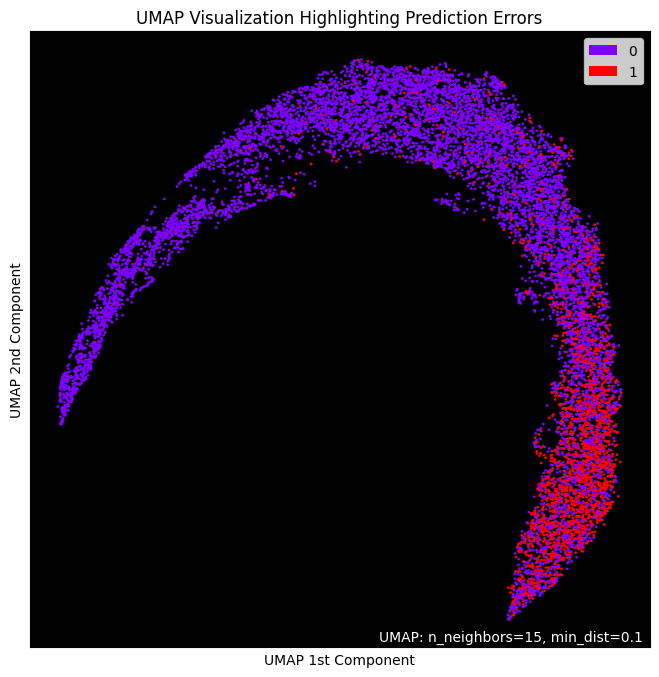

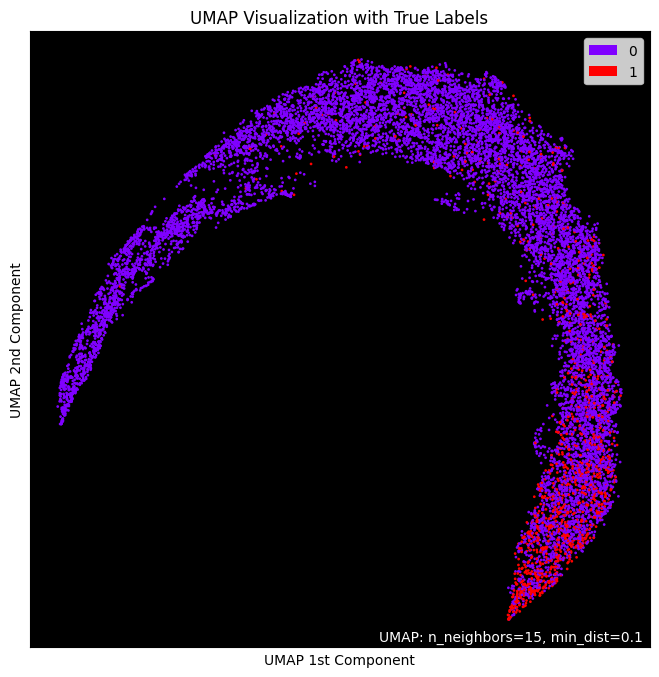

In [ ]:
# Error and Label Lists
errors = [0 if y_pred[ix,0] == y_test.values[ix] else 1 for ix in range(len(y_pred[:,0]))]
labels = [y_test.values[ix] for ix in range(len(y_pred[:,0]))]

# Visualization using UMAP
umap.plot.points(mapper, labels=np.array(errors), theme='fire')
plt.gca().set_title('UMAP Visualization Highlighting Prediction Errors')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

umap.plot.points(mapper, labels=np.array(labels), theme='fire')
plt.gca().set_title('UMAP Visualization with True Labels')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

# # Scatter Plot for 2D UMAP Visualization
# x_coords = embedding[:, 0]
# y_coords = embedding[:, 1]
# plt.scatter(x_coords, y_coords, c=labels, cmap='jet', s=15, alpha=0.6, edgecolors='w')
# plt.xlabel('UMAP 1st component')
# plt.ylabel('UMAP 2nd component')
# plt.colorbar(label='Label')
# plt.title('2D UMAP Visualization with Labels')
# plt.show()

#### SHAP Analysis

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


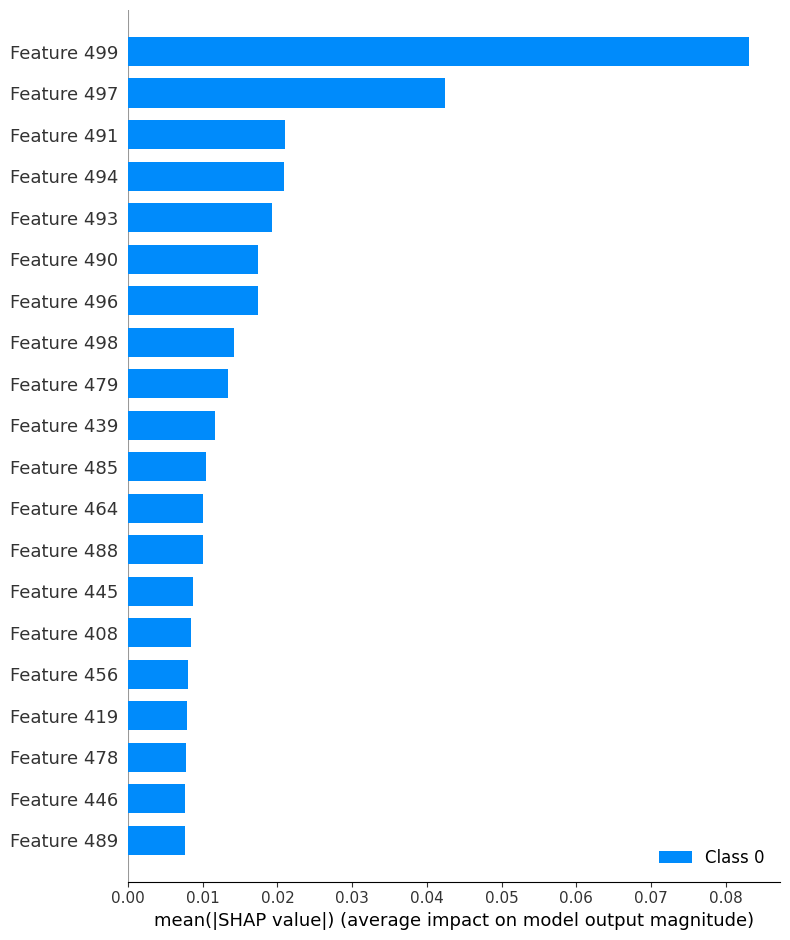

In [ ]:
# SHAP analysis
import shap

# Convert pandas DataFrame to numpy array if needed
X_train_scaled_new_array = np.array(X_train_scaled_new)
X_test_scaled_new_array = np.array(X_test_scaled_new)

# Use a smaller random sample for background
background_sample = X_train_scaled_new_array[np.random.choice(X_train_scaled_new_array.shape[0], 1000, replace=False)]

# Initialize the explainer object
explainer = shap.DeepExplainer(model, background_sample)

# Compute the SHAP values
shap_values = explainer.shap_values(X_test_scaled_new_array)

# Summary plot to show feature importance for the entire dataset
shap.summary_plot(shap_values, X_test_scaled_new_array)



## Deep Neural Network (DNN)

In [ ]:
# Adjust class weight
# class_weight_0 = len(y_train) / (2 * np.sum(y_train == 0))
# class_weight_1 = len(y_train) / (2 * np.sum(y_train == 1))
# class_weights = {0: class_weight_0, 1: class_weight_1}

from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


model = Sequential()
model.add(Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, sample_weight=sample_weights, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 4s 4ms/step - loss: 0.5535 - accuracy: 0.6628 - val_loss: 0.4844 - val_accuracy: 0.7336 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4458 - accuracy: 0.7674 - val_loss: 0.4458 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4087 - accuracy: 0.7861 - val_loss: 0.4196 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3844 - accuracy: 0.7981 - val_loss: 0.4091 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3679 - accuracy: 0.8032 - val_loss: 0.4327 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3461 - accuracy: 0.8144 - val_loss: 0.3979 - val_accuracy: 0.7905 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 2s 4ms/st

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                32064     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                

Plot Learning Curves

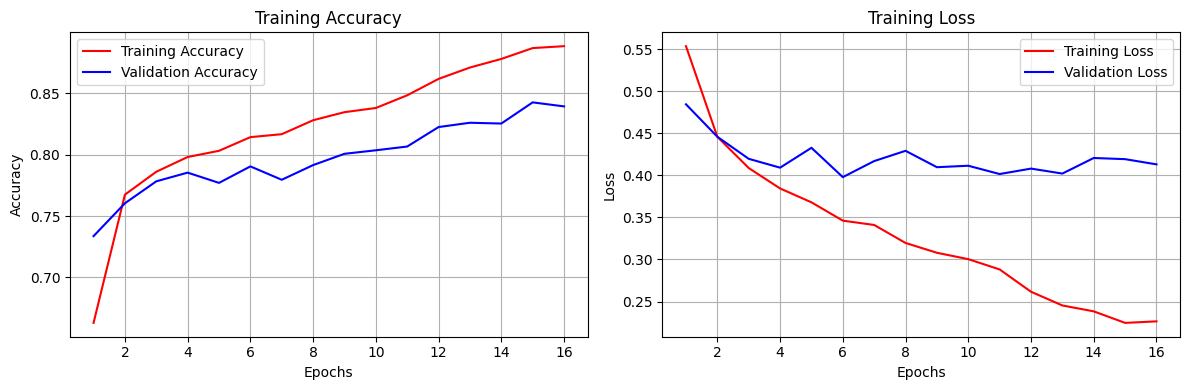

In [ ]:
def plot_learning_curves(history):
    # Extract the training and validation losses & accuracies
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

**DNN Model Evaluation**

In [ ]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled)
dnn_y_train_pred = model.predict(X_train_scaled)

1180/1180 [==============================] - 2s 1ms/step


In [ ]:
print(classification_report(y_test, dnn_y_test_pred.round()))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88     10565
           1       0.32      0.80      0.45      1231

    accuracy                           0.80     11796
   macro avg       0.64      0.80      0.67     11796
weighted avg       0.90      0.80      0.83     11796



In [ ]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

79.88% - Balanced accuracy Test
88.28% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

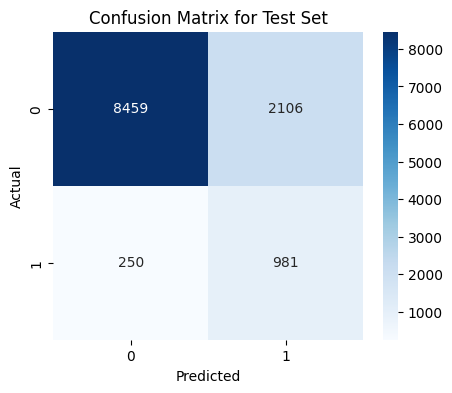

In [ ]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, dnn_y_test_pred.round())
#train_cm = confusion_matrix(y_train, dnn_y_train_pred.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

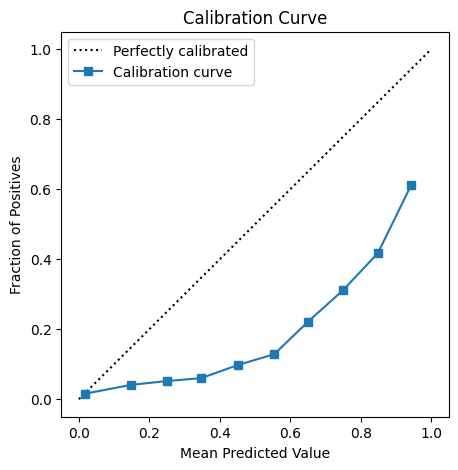

In [ ]:
# calibration curve
dnn_y_test_pred_proba = model.predict_proba(X_test_scaled)
prob_true, prob_pred = calibration_curve(y_test, dnn_y_test_pred_proba, n_bins=10, strategy='uniform')

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Calibration curve')
plt.ylabel('Fraction of Positives')
plt.xlabel('Mean Predicted Value')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Perfectly Calibrated: In a perfectly calibrated model, the calibration curve would be a diagonal line, going from the bottom left corner to the top right corner of the plot (i.e., a 45-degree line, often labeled as "Perfectly calibrated"). This would mean that for items where the model predicts, say, a 70% chance, 70% of those items actually belong to the positive class.

Over-confident: If the curve is below the diagonal line, the model's predicted probabilities are generally higher than the actual fraction of positives, indicating over-confidence.

## Random Forest (Dan)

- We start to tune the base model classifier to give us the best balanced accuracy score, as well as the F1

In [37]:
from sklearn.ensemble import RandomForestClassifier
# define labels
labels = ['0', '1']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [38]:
rf_y_pred = rf.predict(X_test_scaled)
rf_y_train_pred = rf.predict(X_train_scaled)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     10463
         1.0       0.76      0.07      0.13      1333

    accuracy                           0.89     11796
   macro avg       0.83      0.53      0.54     11796
weighted avg       0.88      0.89      0.85     11796



53.60% - Balanced accuracy Test
99.86% - Balanced accuracy Train


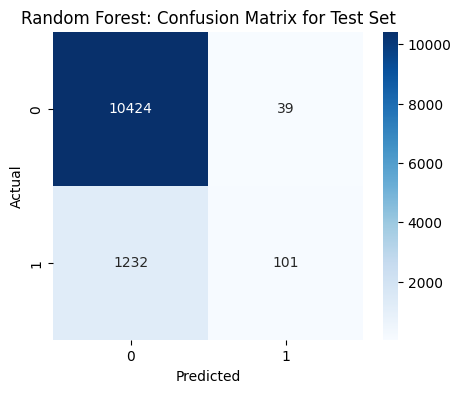

In [66]:

def cm_plot_ba(y_true, y_pred, y_train, y_train_pred, labels, title):
    test_cm = confusion_matrix(y_true, y_pred.round())
    train_cm = confusion_matrix(y_train, y_train_pred.round())
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f'{title}: Confusion Matrix for Test Set')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    print(f"{balanced_accuracy_score(y_true, y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
    print(f"{balanced_accuracy_score(y_train, y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

cm_plot_ba(y_test, rf_y_pred, y_train, rf_y_train_pred, labels, 'Random Forest')

In [46]:
# look for the best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# parameter grid for searching
param = {'n_estimators': np.linspace(50, 100, 10, dtype=int),
         'max_depth': np.linspace(5, 50, 10, dtype=int),
         }

In [47]:
scorer = make_scorer(f1_score, average='weighted')
grid_rf = GridSearchCV(estimator=rf, param_grid=param, scoring=scorer, n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
                         'n_estimators': array([ 50,  55,  61,  66,  72,  77,  83,  88,  94, 100])},
             scoring=make_scorer(f1_score, average=weighted))

In [48]:
best_params = grid_rf.best_params_
best_params

{'max_depth': 40, 'n_estimators': 55}

In [52]:
# using the best parameters
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'],random_state=42)
rf.fit(X_train_scaled, y_train)

rf_y_pred = rf.predict(X_test_scaled)
rf_y_train_pred = rf.predict(X_train_scaled)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     10463
         1.0       0.72      0.08      0.14      1333

    accuracy                           0.89     11796
   macro avg       0.81      0.54      0.54     11796
weighted avg       0.87      0.89      0.85     11796



53.60% - Balanced accuracy Test
99.86% - Balanced accuracy Train


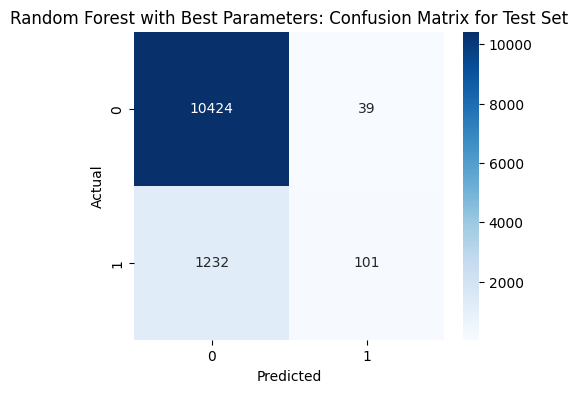

In [67]:
# confusion matrix
cm_plot_ba(y_test, rf_y_pred, y_train, rf_y_train_pred, labels, 'Random Forest with Best Parameters')

In [53]:
from sklearn.tree import plot_tree

# Visualizing the first decision tree
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], filled=True, max_depth=2, feature_names=X.columns)
plt.show()

InvalidParameterError: The 'feature_names' parameter of plot_tree must be an instance of 'list' or None. Got Index(['DIAGNOSIS_UNSTABLE ANGINA\CATH', 'ROUTE_SCIVPOPR', 'ROUTE_PO/NGIVSCIH',
       'ROUTE_POIVIHSCTP', 'virus', 'ROUTE_IVSCPOIHTP', 'ROUTE_IVSCPO/NGIH',
       'DIAGNOSIS_HYPOGLYCEMIA',
       'DIAGNOSIS_CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA',
       'ROUTE_POIVSCTPPRIH',
       ...
       'Procedure: Catheterization and Ventilation Techniques',
       'DISCHARGE_LOCATION_SNF',
       'Procedure: Contrast Imaging and Spleen Procedures',
       'klebsiella pneumoniae', 'enterococcus sp', 'RBC', 'S',
       'AGE_AT_ADMISSION', 'admission_duration_days', 'WBC'],
      dtype='object', length=500) instead.

<Figure size 2000x1000 with 0 Axes>

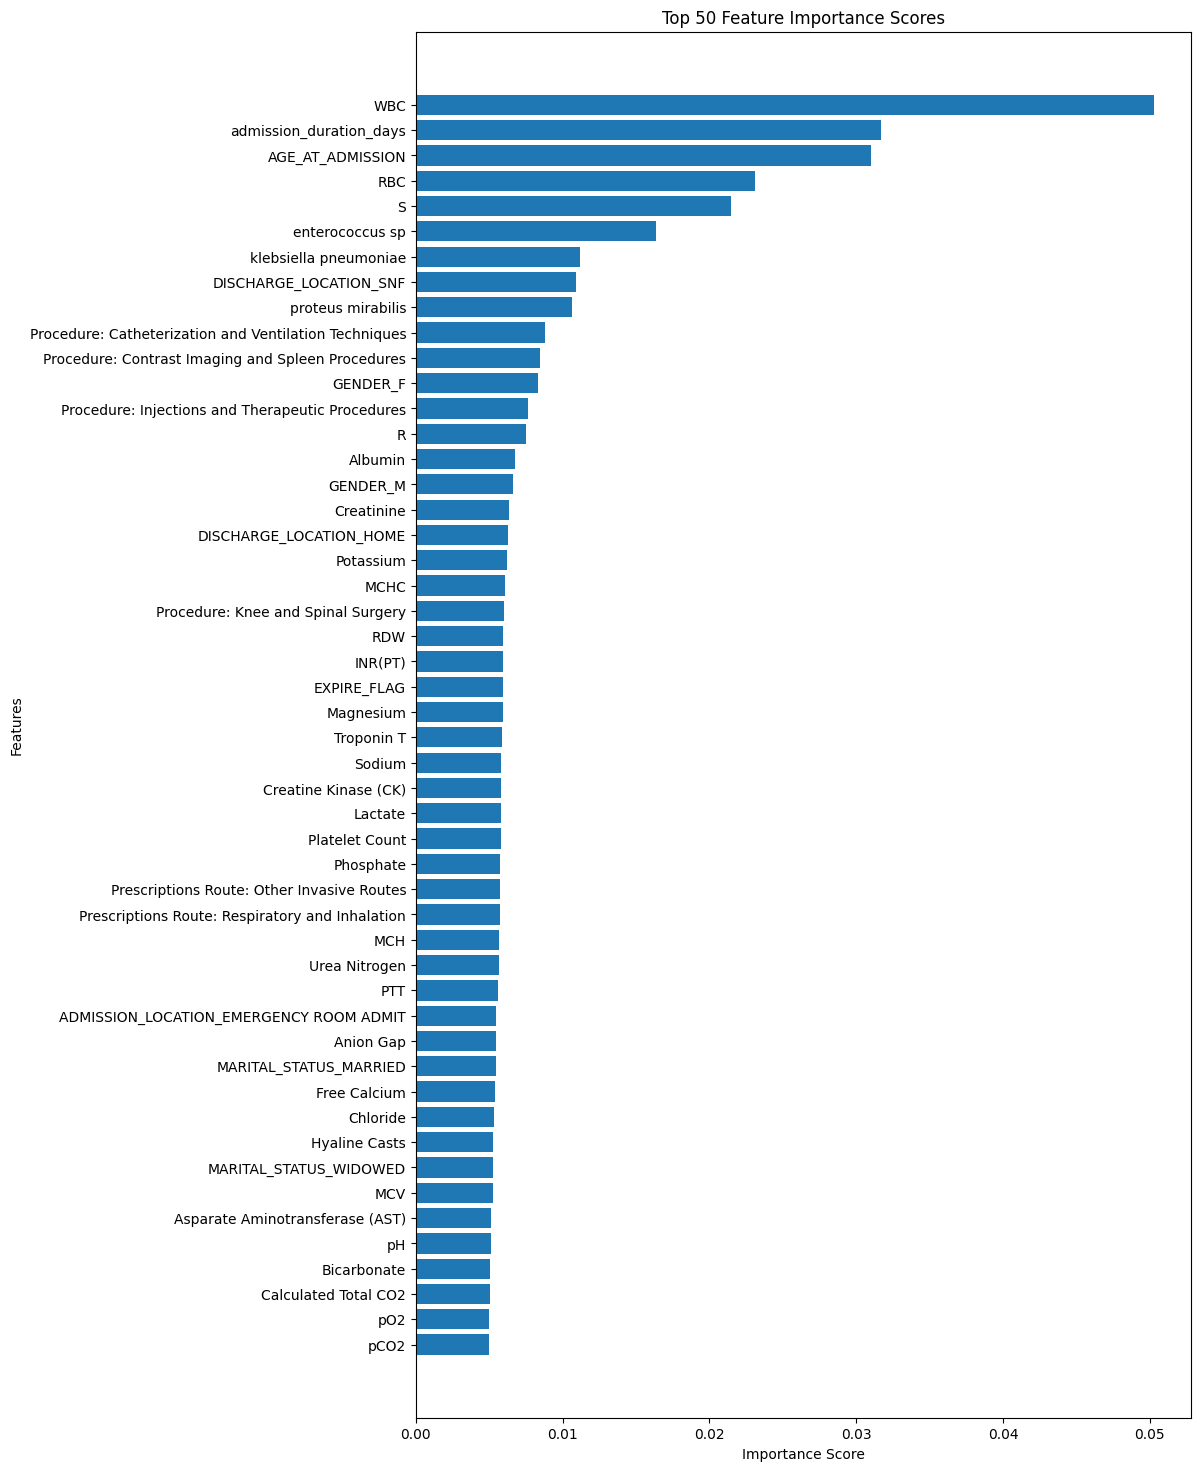

In [51]:
importances = rf.feature_importances_
features = X.columns

# Get the indices of the top 50 features
sorted_indices = np.argsort(importances)[-50:]

plt.figure(figsize=(10,18))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance Scores')
plt.show()


## XGBoost

In [55]:
import xgboost as xgb

# Create and train the model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# predict using test set
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_train_predictions = xgb_model.predict(X_train_scaled)

# show classification report
print("XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_predictions))

XGBoost Classification Report:

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     10463
         1.0       0.59      0.29      0.39      1333

    accuracy                           0.90     11796
   macro avg       0.75      0.63      0.67     11796
weighted avg       0.88      0.90      0.88     11796



In [56]:
# Testing other objective functions for classification
objective = ['binary:logistic', 'binary:hinge', 'binary:logitraw']

for obj in objective:
    xgb_model = xgb.XGBClassifier(objective=obj, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)
    xgb_predictions = xgb_model.predict(X_test_scaled)
    print(f"XGBoost Classification Report for {obj}:\n")
    print(classification_report(y_test, xgb_predictions))
    print(f"{balanced_accuracy_score(y_test, xgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
    print(f"{balanced_accuracy_score(y_train, xgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")
    print('----------------------------')

XGBoost Classification Report for binary:logistic:

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     10463
         1.0       0.59      0.29      0.39      1333

    accuracy                           0.90     11796
   macro avg       0.75      0.63      0.67     11796
weighted avg       0.88      0.90      0.88     11796

63.26% - Balanced accuracy Test
76.13% - Balanced accuracy Train
----------------------------
XGBoost Classification Report for binary:hinge:

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94     10463
         1.0       0.53      0.25      0.34      1333

    accuracy                           0.89     11796
   macro avg       0.72      0.61      0.64     11796
weighted avg       0.87      0.89      0.87     11796

61.09% - Balanced accuracy Test
76.13% - Balanced accuracy Train
----------------------------
XGBoost Classification Report for binary:logitraw:

     

In [57]:
# using binary:logistic
# Create and train the model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# predict using test set
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_train_predictions = xgb_model.predict(X_train_scaled)

# show classification report
print("XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_predictions))

XGBoost Classification Report:

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     10463
         1.0       0.59      0.29      0.39      1333

    accuracy                           0.90     11796
   macro avg       0.75      0.63      0.67     11796
weighted avg       0.88      0.90      0.88     11796



63.26% - Balanced accuracy Test
76.13% - Balanced accuracy Train


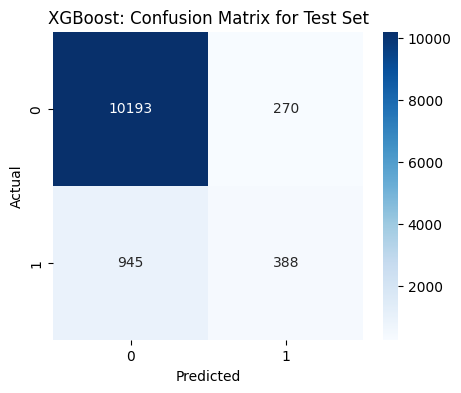

In [68]:
# confusion matrix
cm_plot_ba(y_test, xgb_predictions, y_train, xgb_train_predictions, labels, 'XGBoost')

### Hyperparameter Tuning for XGBoost

In [68]:
# tune hyperparameters for binary:logistic

# parameter grid for searching
param_xgb_logit = {'n_estimators': np.linspace(50, 500, 5, dtype=int),
                   'learning_rate': np.linspace(0.01, 0.2, 10),
                     'max_depth': [3,4,5]}

balanced_scorer = make_scorer(balanced_accuracy_score)
scorer = make_scorer(f1_score, average='weighted')
grid_xgb_logit = GridSearchCV(estimator=xgb_model, param_grid=param_xgb_logit, scoring=balanced_scorer, n_jobs=-1)
grid_xgb_logit.fit(X_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.17888888...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=450,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                         'max_depth': [3, 4, 5],
                         'n_estimators': array([ 50, 162, 275, 387, 500])},
             scoring=make_scorer(balanced_accuracy_score))

In [69]:
best_params_xgb_binlog = grid_xgb_logit.best_params_
best_params_xgb_binlog

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500}

In [70]:
# run on best parameters
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, n_estimators=best_params_xgb_binlog['n_estimators'], max_depth=best_params_xgb_binlog['max_depth'], learning_rate=best_params_xgb_binlog['learning_rate'])
xgb_model.fit(X_train_scaled, y_train)

# predict using test set
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_train_predictions = xgb_model.predict(X_train_scaled)

# show classification report
print("XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_predictions))

# show balanced accuracy
print(f"{balanced_accuracy_score(y_test, xgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, xgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

XGBoost Classification Report:

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     10463
         1.0       0.56      0.31      0.40      1333

    accuracy                           0.89     11796
   macro avg       0.74      0.64      0.67     11796
weighted avg       0.88      0.89      0.88     11796

64.06% - Balanced accuracy Test
83.43% - Balanced accuracy Train


63.26% - Balanced accuracy Test
76.13% - Balanced accuracy Train


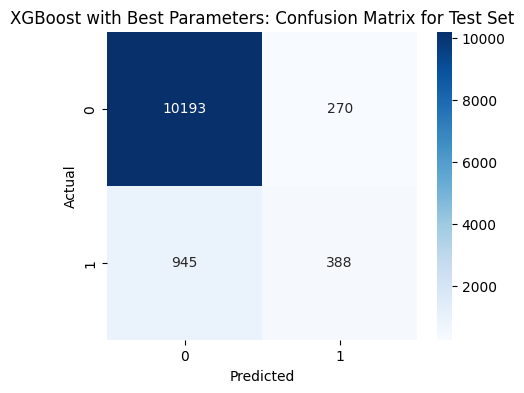

In [69]:
# run on hyperparameters for binary:logistic
cm_plot_ba(y_test, xgb_predictions, y_train, xgb_train_predictions, labels, 'XGBoost with Best Parameters')

## LightGBM

### Base Model

In [61]:
import lightgbm as lgb

# Create and train the model
lgb_model = lgb.LGBMClassifier(objective="binary", random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# predict using test set
lgb_predictions = lgb_model.predict(X_test_scaled)
lgb_train_predictions = lgb_model.predict(X_train_scaled)

# show classification report
print("LightGBM Classification Report:\n")
print(classification_report(y_test, lgb_predictions))

[LightGBM] [Info] Number of positive: 4167, number of negative: 33577
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1980
[LightGBM] [Info] Number of data points in the train set: 37744, number of used features: 489
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110402 -> initscore=-2.086645
[LightGBM] [Info] Start training from score -2.086645
LightGBM Classification Report:

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     10463
         1.0       0.62      0.25      0.36      1333

    accuracy                           0.90     11796
   macro avg       0.77      0.62      0.65     11796
weighted avg       0.88      0.90      0.88     11796



In [62]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, lgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, lgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

61.63% - Balanced accuracy Test
69.37% - Balanced accuracy Train


61.63% - Balanced accuracy Test
69.37% - Balanced accuracy Train


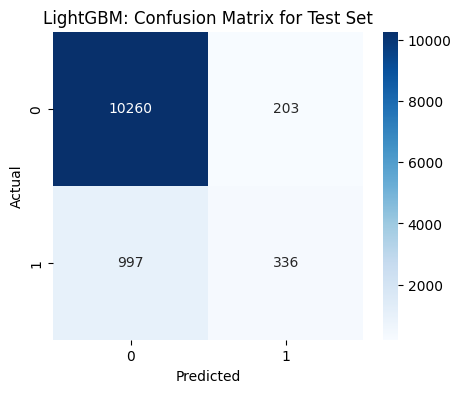

In [70]:
cm_plot_ba(y_test, lgb_predictions, y_train, lgb_train_predictions, labels, 'LightGBM')

### Hyperparameter Tuning Skeleton for LightGBM

In [33]:
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test)

param_grid = {
    'boosting_type': ['gbdt'],
    'objective': ['binary'],
    'metric': ['binary_logloss'],
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'bagging_freq': [1, 3, 5],
    'min_child_samples': [10, 20, 30],
}

clf = lgb.LGBMClassifier()
clf.fit(X_train_scaled, y_train)

#tuning hyperparameters
grid_clf= GridSearchCV(clf, param_grid, verbose=1, cv=3, n_jobs=-1)
grid_clf.fit(X_train_scaled, y_train)

best_params = grid_clf.best_params_

print(best_params)

[LightGBM] [Info] Number of positive: 4167, number of negative: 33577
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1980
[LightGBM] [Info] Number of data points in the train set: 37744, number of used features: 489
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110402 -> initscore=-2.086645
[LightGBM] [Info] Start training from score -2.086645
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_

KeyboardInterrupt: 

In [34]:
# fit model with best parameters
lgb_best = lgb.LGBMClassifier(**best_params)
lgb_best.fit(X_train_scaled, y_train)

# predict using test set
lgb_predictions = lgb_best.predict(X_test_scaled)
lgb_train_predictions = lgb_best.predict(X_train_scaled)

# show classification report
print("LightGBM Classification Report:\n")
print(classification_report(y_test, lgb_predictions))

# show balanced accuracy
print(f"{balanced_accuracy_score(y_test, lgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, lgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 4167, number of negative: 33577
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

61.63% - Balanced accuracy Test
69.37% - Balanced accuracy Train


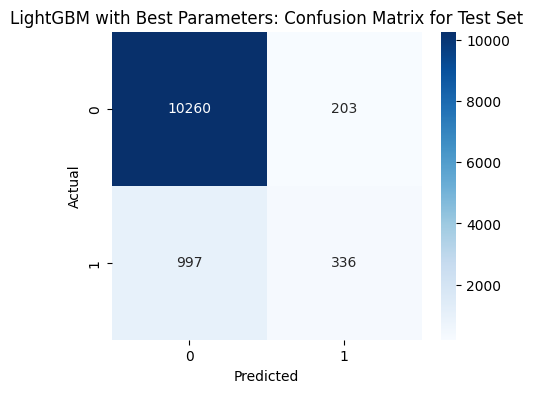

In [71]:
cm_plot_ba(y_test, lgb_predictions, y_train, lgb_train_predictions, labels, 'LightGBM with Best Parameters')

## Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create and train the model with balanced class weights and increased iterations
logistic_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Predict using test set
logistic_predictions = logistic_model.predict(X_test_scaled)
logistic_train_predictions = logistic_model.predict(X_train_scaled)

# Show classification report
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, logistic_predictions))


Logistic Regression Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89     10463
         1.0       0.36      0.78      0.49      1333

    accuracy                           0.81     11796
   macro avg       0.66      0.80      0.69     11796
weighted avg       0.90      0.81      0.84     11796



In [ ]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, logistic_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, logistic_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

79.94% - Balanced accuracy Test
82.82% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

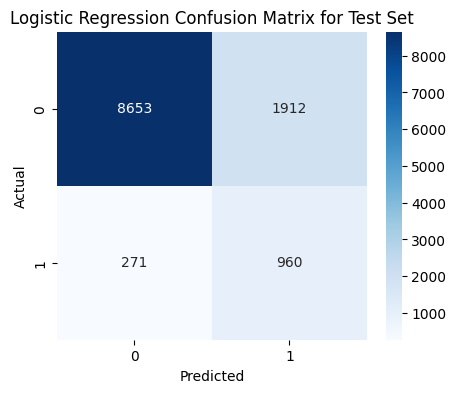

In [ ]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, logistic_predictions.round())
train_cm = confusion_matrix(y_train, logistic_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Logistic Regression Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

**SHAP (SHapley Additive exPlanations)**

Explain the output of machine learning models and identifying feature importance by using Shapley values to fairly allocate contributions of each feature for individual predictions.

In [ ]:
!pip install shap

In [ ]:
import shap

# Get feature names
feature_names = X.columns.tolist()

# # Convert training and test sets to DataFrames with those feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Initialize the explainer object with the appropriate masker
masker = shap.maskers.Independent(data=X_train_scaled)
explainer = shap.LinearExplainer(logistic_model, masker=masker)

# Compute SHAP values for a particular set (e.g., test set)
shap_values = explainer(X_test_scaled)

# force plot for the first instance
# shap.initjs()
# shap.plots.force(shap_values[0])

# Summary plot to show feature importance for the entire dataset
shap.summary_plot(shap_values, X_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


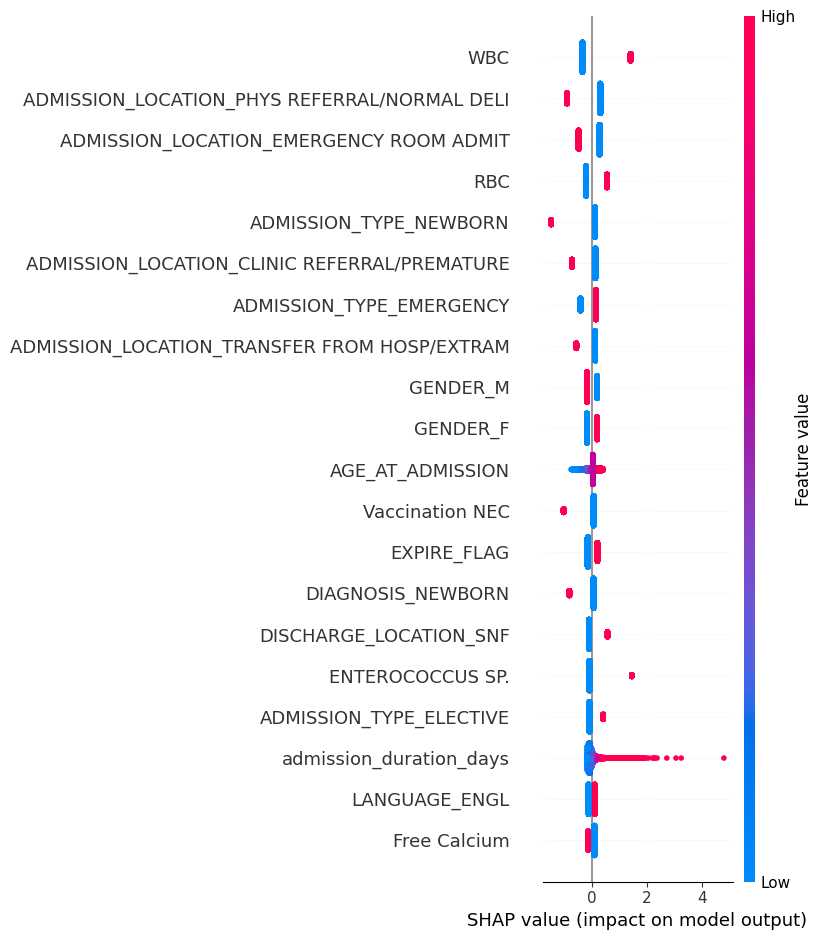

Red: Feature has a high value for that observation

Blue: Feature has a low value for that observation

Position on the x-axis: Indicates the effect of that value on the output

## ROC Curve for all models

369/369 [==============================] - 1s 1ms/step


X has feature names, but LogisticRegression was fitted without feature names


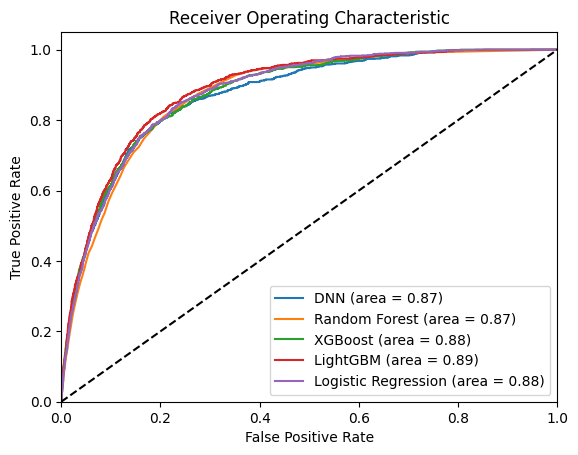

In [ ]:
from sklearn.metrics import roc_curve, auc

# For DNN
y_pred_dnn = model.predict(X_test_scaled).ravel()
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# For Random Forest
y_pred_rf = rf.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# For XGBoost
y_pred_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# For LightGBM
y_pred_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, y_pred_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# For Logistic Regression
y_pred_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_pred_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plotting
plt.figure()
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (area = {roc_auc_dnn:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (area = {roc_auc_lgb:.2f})')
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (area = {roc_auc_logistic:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
